In [15]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
from tqdm.auto import tqdm
from urllib.request import urlretrieve
from zipfile import ZipFile
from torch.utils.data import Dataset
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import glob
import torch.optim as optim
import evaluate
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [16]:
def seed_everything(seed_value):
   np.random.seed(seed_value)
   torch.manual_seed(seed_value)
   torch.cuda.manual_seed_all(seed_value)
   torch.backends.cudnn.deterministic = True
   torch.backends.cudnn.benchmark = False
 
seed_everything(42)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [18]:
device

device(type='cuda')

In [34]:
def download_and_unzip(url, zip_path, dataset_path):
    print(f"Downloading and extracting assets....", end="")
    urlretrieve(url, zip_path)

    try:
        with ZipFile(zip_path) as z:
            z.extractall(dataset_path)
        print("Done")
    except Exception as e:
        print("\nInvalid file", e)
 
URL = r"https://storage.teklia.com/public/rimes2011/RIMES-2011-Lines.zip"
zip_path = os.path.join(os.getcwd(), "RIMES-2011-Lines")
dataset_path = os.path.join(os.getcwd(), "dataset")

if not os.path.exists(zip_path):
    download_and_unzip(URL, zip_path, dataset_path)

In [21]:
torch.cuda.empty_cache()

In [22]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-handwritten")
model = VisionEncoderDecoderModel.from_pretrained(
    'microsoft/trocr-small-stage1'
).to(device)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [24]:
class RIMESDataset(Dataset):
   def __init__(self, root_dir, df, processor, max_target_length=128):
       self.root_dir = root_dir
       self.df = df
       self.processor = processor
       self.max_target_length = max_target_length
       self.batch_size = 4
 
       self.df['text'] = self.df['text'].fillna('')
 
 
   def __len__(self):
       return len(self.df)
 
 
   def __getitem__(self, idx):
       file_name = self.df['file_name'][idx]
       text = self.df['text'][idx]

       image = Image.open(file_name).convert('RGB')
       pixel_values = self.processor(image, return_tensors='pt').pixel_values
       labels = self.processor.tokenizer(
           text,
           padding='max_length',
           max_length=self.max_target_length
       ).input_ids

       labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
       encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
       return encoding

In [25]:
def get_text(transcription_path):
    with open(transcription_path) as f_transcription:
        transcription = f_transcription.readline().strip()
    return transcription

In [26]:
def prepare_RIMES(dataset_path, file):
    set_path = os.path.join(dataset_path, 'Sets')
    images_path = os.path.join(dataset_path, 'Images')
    text_path = os.path.join(dataset_path, 'Transcriptions')
    dataset ={'file_name': [], 'text': []} 

    with open(os.path.join(set_path, file)) as f:
        for val in f:
            dataset['file_name'].append(os.path.join(images_path, val.strip() + '.jpg'))
            text = get_text(os.path.join(text_path, val.strip() + '.txt'))
            dataset['text'].append(text) 
            
    return pd.DataFrame(dataset)

In [27]:
dataset_path=os.path.join('dataset', 'RIMES-2011-Lines')

In [28]:
train_df = prepare_RIMES(dataset_path, 'TrainLines.txt')
test_df = prepare_RIMES(dataset_path, 'TestLines.txt')

In [29]:
train_dataset = RIMESDataset(root_dir=dataset_path,
                           df=train_df,
                           processor=processor)
test_dataset = RIMESDataset(root_dir=dataset_path,
                           df=test_df,
                           processor=processor)

In [30]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
eval_dataloader = DataLoader(test_dataset, batch_size=4)

In [31]:
cer_metric = evaluate.load('cer')
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [32]:
wer_metric = evaluate.load('wer')
def compute_wer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return wer

In [33]:
accumulation_steps = 4
num_epochs = 60

In [27]:
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
cer_vals = []
wer_vals = []
loss_vals = []

In [ ]:
for epoch in range(num_epochs): 
    model.train()
    batch_idx = 0
    for batch in tqdm(train_dataloader):
        for k,v in batch.items():
            batch[k] = v.to(device)
  
        outputs = model(**batch) 

        outputs["loss"] = outputs["loss"] / accumulation_steps
        outputs["loss"].backward()

        if not batch_idx % accumulation_steps:
            optimizer.step()
            optimizer.zero_grad()

        if not batch_idx % 300:
            print(f"Epoch: {epoch+1:04d}/{num_epochs:04d} "
                    f"| Batch {batch_idx:04d}/{len(train_dataloader):04d} "
                    f"| Loss: {outputs['loss']:.4f}")

        batch_idx += 1
    loss_vals.append(outputs['loss'])    
    model.eval()
    valid_cer = 0.0
    valid_wer = 0.0 
    with torch.no_grad():
        for batch in tqdm(eval_dataloader):
            outputs = model.generate(batch["pixel_values"].to(device))
            cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
            wer = compute_wer(pred_ids=outputs, label_ids=batch["labels"])
         
            valid_cer += cer
            valid_wer += wer
    
    cer_vals.append(valid_cer / len(eval_dataloader))
    wer_vals.append(valid_wer / len(eval_dataloader)) 
    print("Validation CER:", valid_cer / len(eval_dataloader))
    print("Validation WER:", valid_wer / len(eval_dataloader))

In [24]:
torch.cuda.max_memory_allocated(device)

2789782528

In [25]:
torch.cuda.max_memory_reserved(device)

7608467456

In [26]:
torch.cuda.memory_reserved(device)

3235905536

In [39]:
import matplotlib.pyplot as plt

In [ ]:
for l in loss_vals:
    print(f"{l:.4f}")
    print(float(l))

t = loss_vals
res = []
for l in t:
    l = float(l)
    res.append(l)

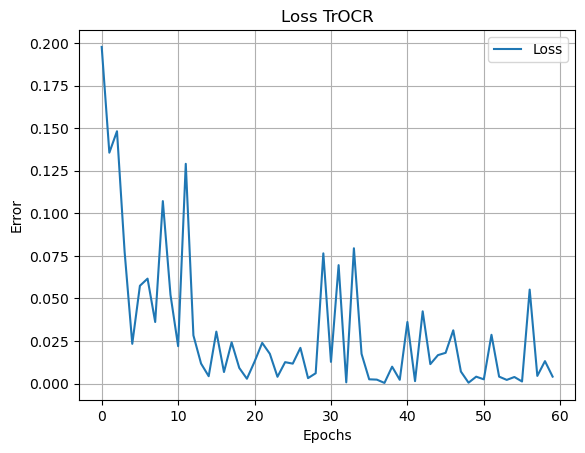

In [60]:
losss, = plt.plot(res)
plt.legend([losss], ['Loss'])
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("Loss TrOCR")
plt.grid()
plt.show()

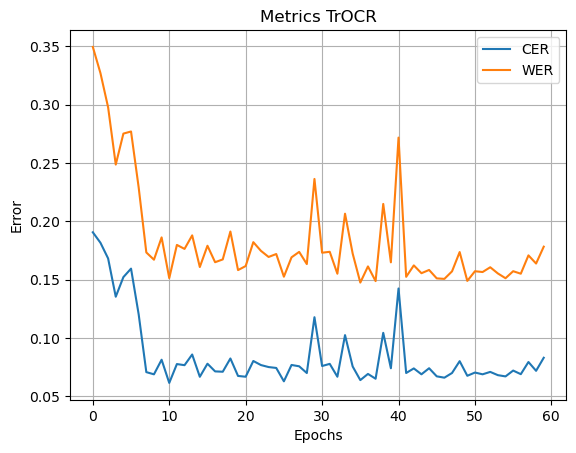

In [58]:
cer_line, = plt.plot(cer_vals)
wer_line, = plt.plot(wer_vals)
plt.legend([cer_line, wer_line], ['CER', 'WER'])
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("Metrics TrOCR")
plt.grid()
plt.show()